In [29]:
import matplotlib

import matplotlib.pyplot as plt

import os
import torch 
import numpy as np
import copy
import importlib

import data
import tools
import arguments
from model import Model
import argparse

In [2]:
# Create settings
parser = argparse.ArgumentParser()
parser=arguments.add_arguments(parser)
FLAGS, others = parser.parse_known_args()
# Adjust settings
FLAGS.load_data_in_ram=True
FLAGS.dataset = 'esatv3_expert/2500'
FLAGS.log_tag = 'test_nearest_features'
# FLAGS.checkpoint_path = 'chapter_policy_learning/how_to_recover/res18_reference/final/3'
# FLAGS.checkpoint_path = 'chapter_neural_architectures/output/res18_continuous/final/1'
FLAGS.checkpoint_path = 'chapter_neural_architectures/data_normalization/alex_scaled_input_normalized_output/final/1'
FLAGS.batch_size = 32
if FLAGS.summary_dir[0] != '/': 
    FLAGS.summary_dir = os.path.join(os.getenv('HOME'),FLAGS.summary_dir)
if len(FLAGS.checkpoint_path) != 0 and FLAGS.checkpoint_path[0] != '/': 
    FLAGS.checkpoint_path = os.path.join(FLAGS.summary_dir, FLAGS.checkpoint_path) 
if not os.path.isdir(FLAGS.summary_dir+FLAGS.log_tag): 
    os.makedirs(FLAGS.summary_dir+FLAGS.log_tag)
FLAGS=tools.load_config(FLAGS, FLAGS.checkpoint_path)

# Load a model
mymodel = Model(FLAGS)

[tools] Load configuration from:  /esat/opal/kkelchte/docker_home/tensorflow/log/chapter_neural_architectures/data_normalization/alex_scaled_input_normalized_output/final/1
set: action_bound 0.9
set: auxiliary_depth False
set: depth_multiplier 0.25
set: discrete True
set: n_frames 2
set: network alex_net
set: normalized_input False
set: scaled_input True
set: skew_input False
set: speed 0.8
set: stochastic False
set: turn_speed 0.8
[model.py]: Divided 3 discrete actions over [-0.9, 0.0, 0.9] with boundaries [-0.45, 0.45].
[model] Total number of trainable parameters: 57016131
[model]: loaded model from /esat/opal/kkelchte/docker_home/tensorflow/log/chapter_neural_architectures/data_normalization/alex_scaled_input_normalized_output/final/1 at epoch: 10000
[model]: loaded optimizer parameters from /esat/opal/kkelchte/docker_home/tensorflow/log/chapter_neural_architectures/data_normalization/alex_scaled_input_normalized_output/final/1


In [4]:
def extract_features(dataset):
    """Extract features in batches and returns a pytorch tensor on cpu with features.
    """
    # For each frame extract features
    features=torch.FloatTensor()
    FLAGS.batch_size=32
    for frame_index in range(0,len(dataset['num_imgs']),FLAGS.batch_size):
        if not FLAGS.load_data_in_ram:
            frames = [tools.load_rgb(im_file=os.path.join(dataset['name'],'RGB', '{0:010d}.jpg'.format(dataset['num_imgs'][sample_index])), 
                                          im_size=model.input_size, 
                                          im_mode='CHW',
                                          im_norm='scaled' if FLAGS.scaled_input else 'none',
                                          im_means=FLAGS.normalize_means,
                                          im_stds=FLAGS.normalize_stds) for sample_index in range(frame_index, min(frame_index+FLAGS.batch_size, len(dataset['num_imgs'])))]
        else:
            frames = dataset['imgs'][frame_index:min(frame_index+FLAGS.batch_size, len(dataset['num_imgs']))]
        inputs=torch.from_numpy(np.asarray(frames)).type(torch.FloatTensor).to(model.device)
        new_features = torch.squeeze(model.net.feature(inputs).flatten(start_dim=1, end_dim=-1)).cpu().detach()
        if features.size() == 0:
            features = newfeatures
        else:
            features = torch.cat((features, new_features), dim=0)
    return features

In [5]:
# Step 1: Load source data and extract features
# Load data in parallel in RAM
data.prepare_data(FLAGS, model.input_size, datatypes=['train'])
source_dataset=copy.deepcopy(data.full_set['train'][0])
# extra features
source_features=extract_features(source_dataset)

[data] 00000_esatv3


In [4]:
# Step 2: Load test data and extract features
FLAGS.load_data_in_ram = True
FLAGS.dataset='esatv3_expert_stochastic/gau'
data.prepare_data(FLAGS, mymodel.input_size, datatypes=['train'])
# use first run of training for test dataset
test_dataset=copy.deepcopy(data.full_set['train'][0] )
# extract features
test_features=extract_features(test_dataset)

[data] 00000_esatv3


NameError: name 'extract_features' is not defined

(224, 224, 3)

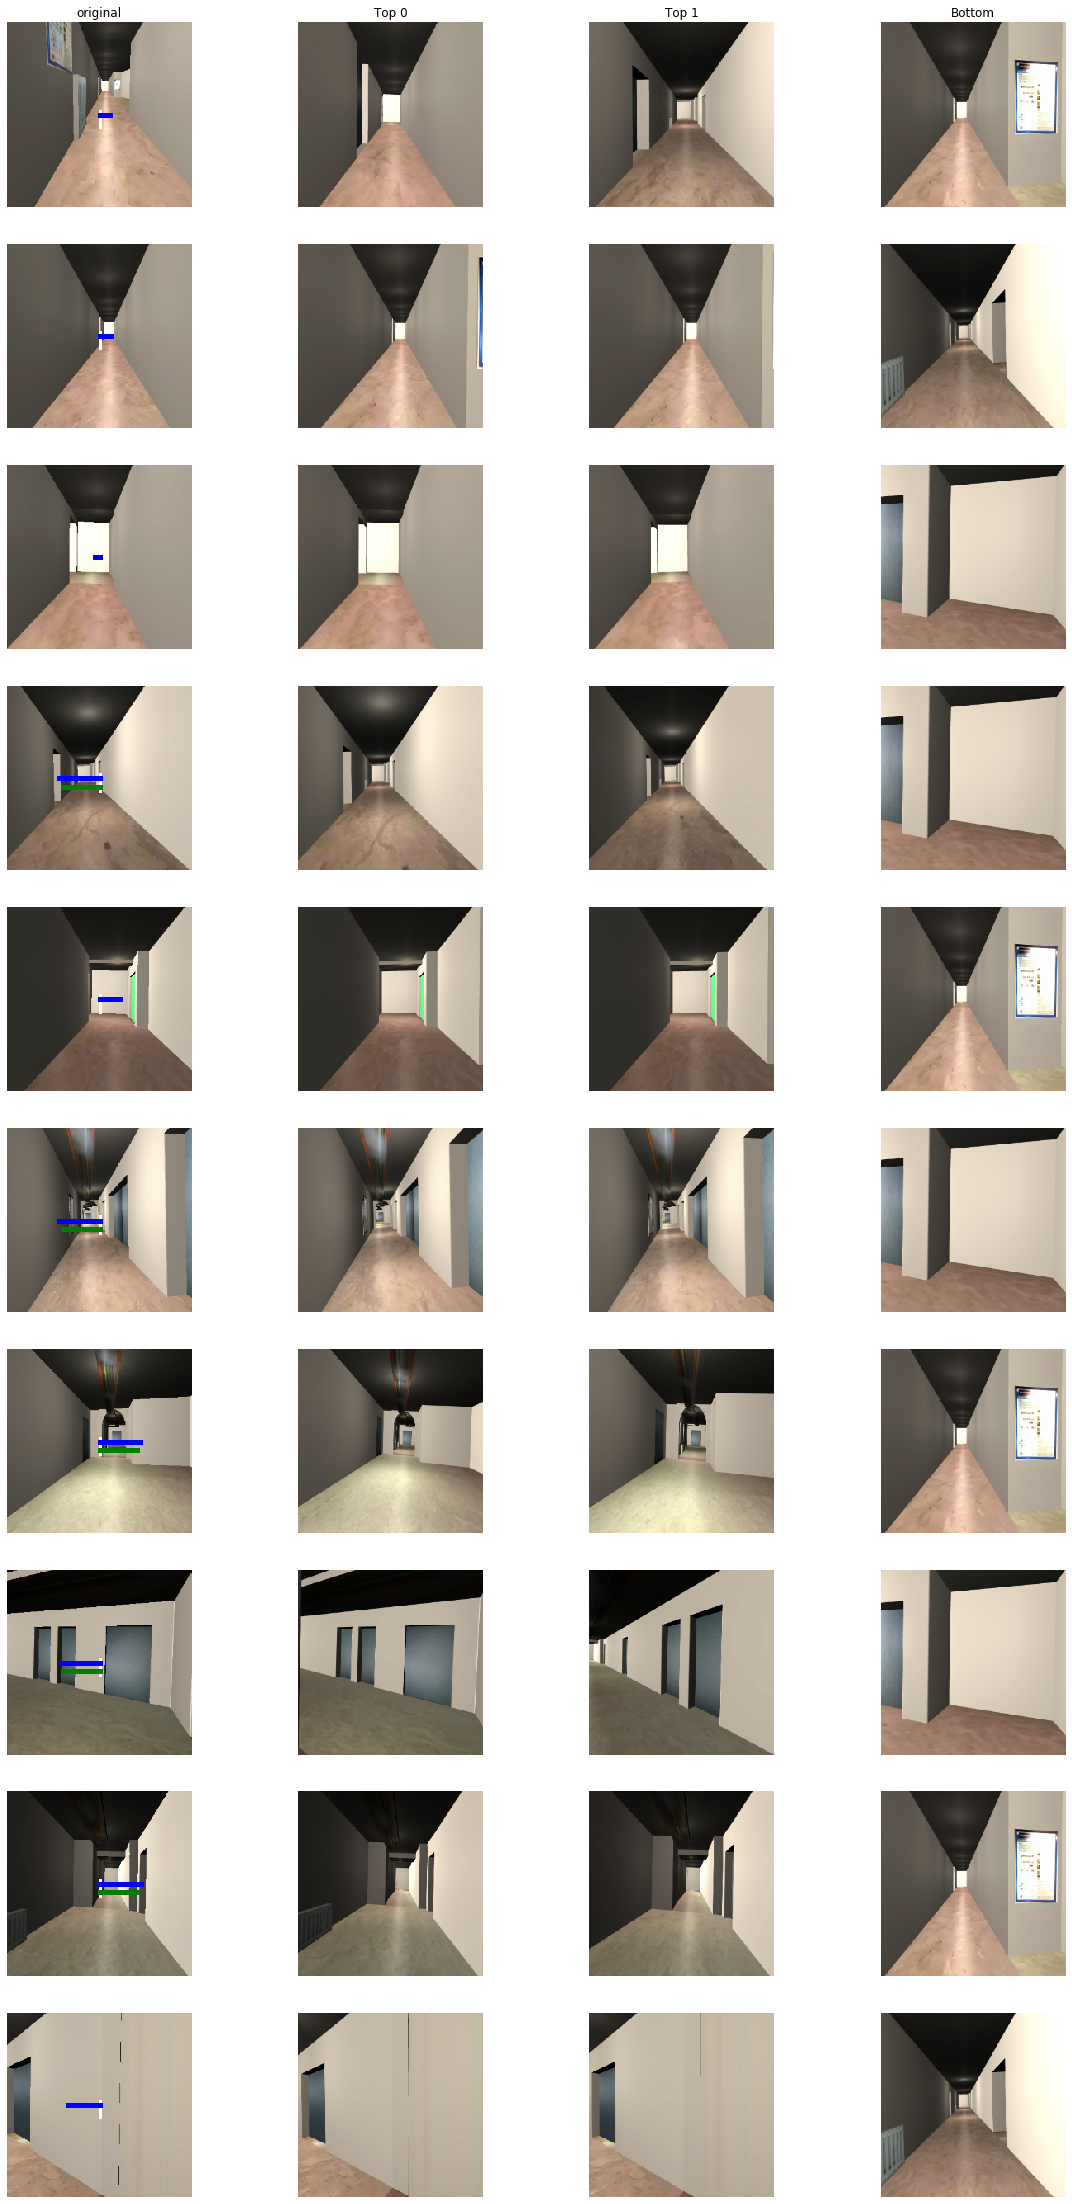

In [17]:
# Step 3: For each test feature calculate distance to all source features
k=2
rows=10
fig,ax=plt.subplots(rows, k+2,figsize=(20,40),squeeze=False)
for j in range(rows):
    test_frame_index=int(len(test_features)/rows)*j
    distances=(source_features-test_features[test_frame_index]).pow(2).sum(1).sqrt().detach().numpy()
    original=tools.post_process(FLAGS,test_dataset['imgs'][test_frame_index])
    ax[j,0].imshow(original)
    ax[j,0].axis('off')
    
    # add label and predicted control
    label=test_dataset['controls'][test_frame_index]
    ctr,_,_ = model.predict(np.expand_dims(test_dataset['imgs'][test_frame_index],0))
    ax[j,0].plot((original.shape[0]/2,original.shape[0]/2), (original.shape[1]/2-5,original.shape[1]/2+15), linewidth=3, markersize=12,color='w')
    ax[j,0].plot((original.shape[0]/2,original.shape[0]/2-ctr*50), (original.shape[1]/2,original.shape[1]/2), linewidth=5, markersize=12,color='b')
    ax[j,0].plot((original.shape[0]/2,original.shape[0]/2-label*50), (original.shape[1]/2+10,original.shape[1]/2+10), linewidth=5, markersize=12,color='g')

    
    if j ==0: ax[j,0].set_title('original')
    for i in range(k):
        img=tools.post_process(FLAGS, source_dataset['imgs'][np.argsort(distances)[i]])
        ax[j,i+1].imshow(img)
        ax[j,i+1].axis('off')
        if j ==0: ax[j,i+1].set_title('Top '+str(i))
    img=tools.post_process(FLAGS, source_dataset['imgs'][np.argsort(distances)[-1]])
    ax[j,3].imshow(img)
    ax[j,3].axis('off')
    if j ==0: ax[j,3].set_title('Bottom')
    
plt.show()

In [18]:
inputs=torch.from_numpy(np.asarray(np.expand_dims(test_dataset['imgs'][0],0))).type(torch.FloatTensor).to(mymodel.device)
x = mymodel.net.feature(inputs)
x = x.view(x.size(0), -1)
mymodel.net.classify(x)
# mymodel.net.classify(feats)

tensor([[ 1.5116,  3.0301, -4.3207]], device='cuda:0', grad_fn=<AddmmBackward>)

In [44]:
matplotlib.use(be)
grad_cam = tools.GradCam(mymodel.net, target_layer=len(mymodel.net.feature)-1, device=mymodel.device)
inputs=torch.from_numpy(np.asarray(np.expand_dims(test_dataset['imgs'][0],0))).type(torch.FloatTensor).to(mymodel.device)
cam = grad_cam.generate_cam(inputs, 0)

plt.imshow(cam)
plt.show()
# tools.apply_heatmap_on_image(FLAGS,)

In [ ]:
# Step 4: Combine closest k (and furthest k) frames in one image